In [1]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import TransformerPayne, METALS, Blackbody
import jax.numpy as jnp
%matplotlib inline

from tqdm import tqdm

In [2]:
b = Blackbody()

In [10]:
body1 = IcosphereModel.construct(100, 8.28, 2.057, b.to_parameters(dict(teff=4930)), b.stellar_parameter_names)
body2 = IcosphereModel.construct(100, 3.94, 1.958, b.to_parameters(dict(teff=6650)), b.stellar_parameter_names)
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, (75.6*u.d).to(u.year).value, 0., 0., jnp.deg2rad(85.68), jnp.deg2rad(65.99), jnp.deg2rad(269.), 0., 0., 0., 50)
times = jnp.linspace(0.05, 0.25, 50)
result = evaluate_orbit_at_times(binary, times)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


Using search radius factor for KD-tree: 2.024972


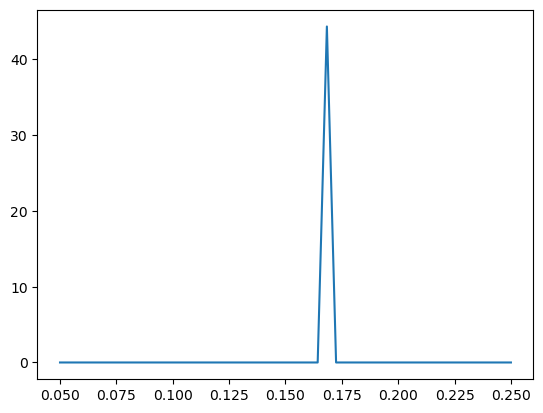

In [11]:
plt.plot(times, np.array([np.sum(r.occluded_areas) for r in result[1]]))

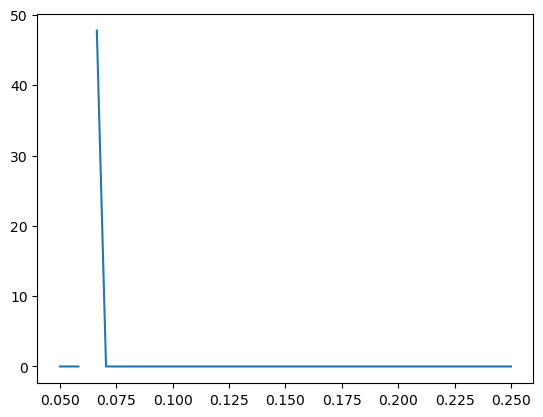

In [12]:
plt.plot(times, np.array([np.sum(r.occluded_areas) for r in result[0]]))

In [23]:
from spice.plots.plot_mesh import *
from spice.plots.plot_mesh import _evaluate_to_be_mapped_property
def _animate_binary(binary1_meshes, binary2_meshes, filename, 
                   property='los_velocities', 
                   timestamps=None, 
                   cmap=None,
                   property_label=None,
                   timestamp_label='days',
                   mode='MESH',
                   skip_frames=1,
                   linewidth=0.01,
                   figure_size=(10, 10),
                   draw_los_vector=True,
                   draw_rotation_axes=True,
                   view_angles=None,
                   fixed_norm=True,
                   scale_radius=1.0):
    """
    Create an animation of a binary system over time.
    
    Parameters
    ----------
    binary1_meshes : List[MeshModel]
        List of mesh models for the first star at different time steps
    binary2_meshes : List[MeshModel]
        List of mesh models for the second star at different time steps
    filename : str
        Output filename for the animation
    property : Union[str, int], default: 'los_velocities'
        Property to color the meshes by (attribute name or parameter index)
    timestamps : Optional[ArrayLike], default: None
        List of timestamps corresponding to each mesh
    cmap : Optional[str], default: None
        Matplotlib colormap name. If None, uses defaults based on property
    property_label : Optional[str], default: None
        Custom label for the colorbar. If None, uses default for the property
    timestamp_label : Optional[str], default: "days"
        Label to accompany timestamps (e.g., "hours", "days")
    mode : str, default: 'MESH'
        Visualization mode - 'MESH' (triangular mesh) or 'POINTS' (scatter)
    skip_frames : int, default: 1
        Only use every nth frame for performance
    linewidth : float, default: 0.01
        Line width for mesh edges
    figure_size : Tuple[int, int], default: (10, 10)
        Size of the figure in inches
    draw_los_vector : bool, default: True
        Whether to draw the line-of-sight vector
    draw_rotation_axes : bool, default: True
        Whether to draw the rotation axes of both stars
    view_angles : Optional[Tuple[float, float]], default: None
        Tuple of (elevation, azimuth) viewing angles. If None, uses default view
    fixed_norm : bool, default: True
        Whether to keep color normalization fixed across all frames
    scale_radius : float, default: 1.0
        Scale factor for both stellar radii
        
    Returns
    -------
    str
        The path to the saved animation file
    """
    if mode.upper() not in ['MESH', 'POINTS']:
        raise ValueError(f'Mode must be one of ["MESH", "POINTS"]. Got {mode.upper()}')
    mode = mode.upper()
    
    # Filter meshes and timestamps using skip_frames
    binary1_meshes = binary1_meshes[::skip_frames]
    binary2_meshes = binary2_meshes[::skip_frames]
    if timestamps is not None:
        timestamps = timestamps[::skip_frames]
    
    # Initial setup
    fig = plt.figure(figsize=figure_size)
    spec = fig.add_gridspec(10, 12)
    plot_ax = fig.add_subplot(spec[:, :10], projection='3d')
    cbar_ax = fig.add_subplot(spec[2:8, 11])
    
    # Get first meshes for initial setup
    mesh1 = binary1_meshes[0]
    mesh2 = binary2_meshes[0]
    
    # If using fixed color normalization across frames, compute min/max across all meshes
    if fixed_norm:
        all_property_values = []
        for i in range(len(binary1_meshes)):
            # Get property values for both stars
            mesh1, mesh2 = binary1_meshes[i], binary2_meshes[i]
            
            # Get property data
            to_be_mapped1, _ = _evaluate_to_be_mapped_property(mesh1, property, property_label)
            to_be_mapped2, _ = _evaluate_to_be_mapped_property(mesh2, property, property_label)
            
            all_property_values.append(np.concatenate([to_be_mapped1, to_be_mapped2]))
        
        all_property_values = np.concatenate(all_property_values)
        vmin, vmax = np.nanmin(all_property_values), np.nanmax(all_property_values)
    else:
        # Just get the property values from the first meshes
        to_be_mapped1, _ = _evaluate_to_be_mapped_property(mesh1, property, property_label)
        to_be_mapped2, _ = _evaluate_to_be_mapped_property(mesh2, property, property_label)
        to_be_mapped = np.concatenate([to_be_mapped1, to_be_mapped2])
        vmin, vmax = np.nanmin(to_be_mapped), np.nanmax(to_be_mapped)
    
    # Get property label
    _, cbar_label = _evaluate_to_be_mapped_property(mesh1, property, property_label)
    
    # Set up axes limits
    axes_lim = np.max(np.abs((mesh1.radius+mesh1.center)-(mesh2.center-mesh2.radius))) * 1.2
    plot_ax.set_xlim3d(-axes_lim, axes_lim)
    plot_ax.set_ylim3d(-axes_lim, axes_lim)
    plot_ax.set_zlim3d(-axes_lim, axes_lim)
    plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
    
    # Set custom view angle if provided
    if view_angles is not None:
        elev, azim = view_angles
        plot_ax.view_init(elev=elev, azim=azim)
    
    # Set up colormap
    if cmap is None:
        from spice.plots.plot_mesh import DEFAULT_PROPERTY_CMAPS, DEFAULT_CMAP
        cmap = DEFAULT_PROPERTY_CMAPS.get(property, DEFAULT_CMAP)
    
    # Set up colormap normalization
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    # Set up colorbar
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label(cbar_label, fontsize=12)
    
    # Title for timestamps
    title = fig.suptitle("", fontsize=14, y=0.98)
    
    # Define the update function for animation
    def update(frame):
        # Clear previous frame elements
        plot_ax.clear()
        
        # Reset axis properties after clearing
        plot_ax.set_xlim3d(-axes_lim, axes_lim)
        plot_ax.set_ylim3d(-axes_lim, axes_lim)
        plot_ax.set_zlim3d(-axes_lim, axes_lim)
        plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
        plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
        plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
        
        # Set custom view angle if provided
        if view_angles is not None:
            elev, azim = view_angles
            plot_ax.view_init(elev=elev, azim=azim)
        
        # Get current meshes
        mesh1 = binary1_meshes[frame]
        mesh2 = binary2_meshes[frame]
        
        # Update timestamp if available
        if timestamps is not None:
            ts_str = f"Time: {timestamps[frame]:.2f} {timestamp_label or ''}"
            title.set_text(ts_str)
        
        # Get property data for current meshes
        to_be_mapped1, _ = _evaluate_to_be_mapped_property(mesh1, property, property_label)
        to_be_mapped2, _ = _evaluate_to_be_mapped_property(mesh2, property, property_label)
        
        # Draw vectors
        if draw_los_vector:
            normalized_los_vector = mesh1.los_vector / np.linalg.norm(mesh1.los_vector)
            plot_ax.quiver(*(-1.5*axes_lim*normalized_los_vector), *((axes_lim*normalized_los_vector)/2),
                    color='red', linewidth=3., label='LOS vector')
        
        if draw_rotation_axes:
            normalized_rotation_axis1 = mesh1.rotation_axis / np.linalg.norm(mesh1.rotation_axis)
            normalized_rotation_axis2 = mesh2.rotation_axis / np.linalg.norm(mesh2.rotation_axis)
            
            plot_ax.quiver(*(mesh1.center+normalized_rotation_axis1*mesh1.radius*scale_radius), 
                           *(mesh1.radius*normalized_rotation_axis1*scale_radius),
                           color='black', linewidth=3., label='Rotation axis of mesh1')
            plot_ax.quiver(*(mesh2.center+normalized_rotation_axis2*mesh2.radius*scale_radius), 
                           *(mesh2.radius*normalized_rotation_axis2*scale_radius),
                           color='blue', linewidth=3., label='Rotation axis of mesh2')
        
        # Visualize the meshes
        if mode == 'MESH':
            # First mesh
            vs2_1 = mesh1.center+(mesh1.mesh_elements-mesh1.center)*scale_radius
            face_colors1 = mpl.colormaps[cmap](norm(to_be_mapped1))
            p1 = art3d.Poly3DCollection(vs2_1, facecolors=face_colors1, edgecolor="black", linewidths=linewidth)
            
            # Second mesh
            vs2_2 = mesh2.center+(mesh2.mesh_elements-mesh2.center)*scale_radius
            face_colors2 = mpl.colormaps[cmap](norm(to_be_mapped2))
            p2 = art3d.Poly3DCollection(vs2_2, facecolors=face_colors2, edgecolor="black", linewidths=linewidth)
            
            plot_ax.add_collection(p1)
            plot_ax.add_collection(p2)
        else:  # mode == 'POINTS'
            # First mesh as points
            centers1 = mesh1.center+(mesh1.centers-mesh1.center)*scale_radius
            plot_ax.scatter(centers1[:, 0], centers1[:, 1], centers1[:, 2],
                           c=to_be_mapped1, cmap=cmap, norm=norm)
            
            # Second mesh as points
            centers2 = mesh2.center+(mesh2.centers-mesh2.center)*scale_radius
            plot_ax.scatter(centers2[:, 0], centers2[:, 1], centers2[:, 2],
                           c=to_be_mapped2, cmap=cmap, norm=norm)
        
        # Only show legend in the first frame
        if draw_los_vector or draw_rotation_axes:
            plot_ax.legend(loc='upper right', fontsize=12)
        
        # Add padding between plot and colorbar
        plt.subplots_adjust(right=0.85)
        
        # Return empty list since we're not using blit=True
        return []
    anim = FuncAnimation(fig, update, frames=len(binary1_meshes), blit=False)
    smart_save(anim, filename, fps=20)
    
    plt.close(fig)
    return filename

In [26]:
from spice.plots.plot_mesh import animate_binary

_animate_binary(result[0], result[1], "tz_fornacis_orbit_visibilities.gif", property="occluded_areas", 
              timestamps=times*365.25, timestamp_label="days", scale_radius=10)

'tz_fornacis_orbit_visibilities.gif'

In [5]:
# from spice.plots.plot_mesh import plot_3D_binary

# i = 24
# plot_3D_binary(result[0][i], result[1][i], property="visible_cast_areas")

In [13]:
from tqdm import tqdm

vws = jnp.log10(jnp.linspace(2000, 8000, 100))
spectra_body1 = [simulate_observed_flux(b.intensity, _pb, vws) for _pb in tqdm(result[0])]
spectra_body2 = [simulate_observed_flux(b.intensity, _pb, vws) for _pb in tqdm(result[1])]

100%|██████████| 50/50 [00:00<00:00, 62.87it/s]


In [14]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import GaiaG, GaiaBP, GaiaRP, Bolometric

bol = Bolometric()
gaia_g = GaiaG()
gaia_bp = GaiaBP()
gaia_rp = GaiaRP()


bol_lum = [AB_passband_luminosity(bol, 10**vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]
gaia_g_lum = [AB_passband_luminosity(gaia_g, 10**vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]
gaia_bp_lum = [AB_passband_luminosity(gaia_bp, 10**vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]
gaia_rp_lum = [AB_passband_luminosity(gaia_rp, 10**vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]

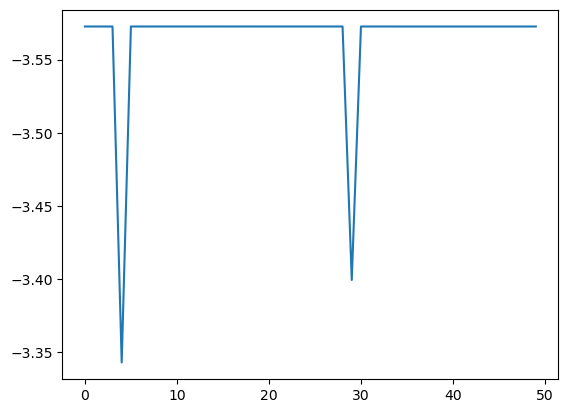

In [15]:
plt.plot(gaia_g_lum);
plt.gca().invert_yaxis();